# Handwritten digit recognition with neural networks

In [106]:
from pathlib import Path
import os
import random

import numpy as np
from numpy.typing import NDArray

from network import NeuralNetwork, Sigmoid, Cost
import utils

SAVE_DIR = Path('../network_data').resolve()

#### MNIST database
Consists of 60000 training samples and 10000 testing samples with labels of 28x28 greyscale images of digits.

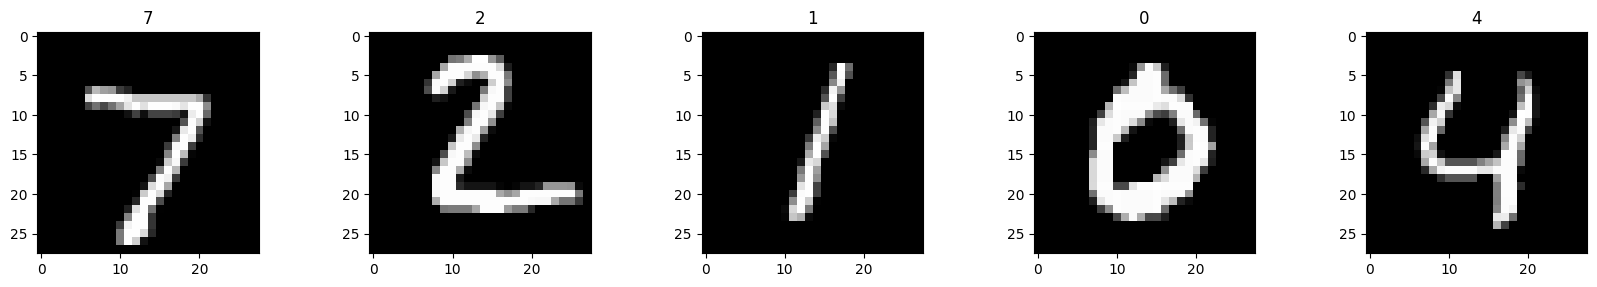

In [107]:
# load data into memory
resources_dir = Path('../resources').resolve()
data = utils.load_mnist(resources_dir)

# show the first five images with labels
utils.plot_images(data.testing_images[:5], data.testing_labels_digits[:5])

#### Training and testing functions
Using minibatch method

In [108]:
def train_network(network: NeuralNetwork, batches: list[tuple[NDArray, NDArray]], epochs: int, scale: float = 1.):
    """Trains the network using minibatch method 'epoch' number of times. Change the 'scale' input to adjust learning speed."""
    for _ in range(epochs):
        for image, label in batches:
            network.backprop_and_apply(image, label, scale)
        
def test_network(network: NeuralNetwork, test_images: NDArray, test_labels: NDArray, cost_tolerance: float) -> float:
    """
    Tests the accuracy of the network using 'test_images' and 'test_labels'.
    Returns the ratio between the correct outputs and all tests, so a number between 0.0 and 1.0.
    """
    assert test_images.shape[0] == test_labels.shape[0]
    num_of_tests = test_images.shape[0]
    out = network(test_images)
    cost = network.cost(out, test_labels)
    passed = np.count_nonzero(cost < cost_tolerance)
    return passed / num_of_tests

#### Training

In [109]:
# settings
mini_batch_size = 1000
num_of_epochs = 1000
learning_scale = 1.2
save_to = 'network.npz'
save = False
train = False

nn = NeuralNetwork.new_network((28 * 28, 16, 16, 10), Sigmoid(), Cost())

# create mini batches
mini_batches = [(data.training_images[i:i+mini_batch_size, ...], data.training_labels[i:i+mini_batch_size, ...]) 
                for i in range(0, data.training_images.shape[0], mini_batch_size)]

# training
if train:
    train_network(nn, mini_batches, num_of_epochs, scale=learning_scale)

# saving to a file for later use
if not SAVE_DIR.exists():
    os.mkdir(SAVE_DIR)
if save:
    nn.save_to_file(SAVE_DIR / save_to, overwrite=True)

#### Testing

In [110]:
get_from_file = True
if get_from_file:
    nn = NeuralNetwork.load_from_file(SAVE_DIR / save_to, Sigmoid(), Cost())

ratio = test_network(nn, data.testing_images, data.testing_labels, 0.1)

f"The network is correct {ratio * 100:.1f}% of the time. ({round(data.testing_images.shape[0] * ratio)}/{data.testing_images.shape[0]})"

'The network is correct 91.5% of the time. (9152/10000)'

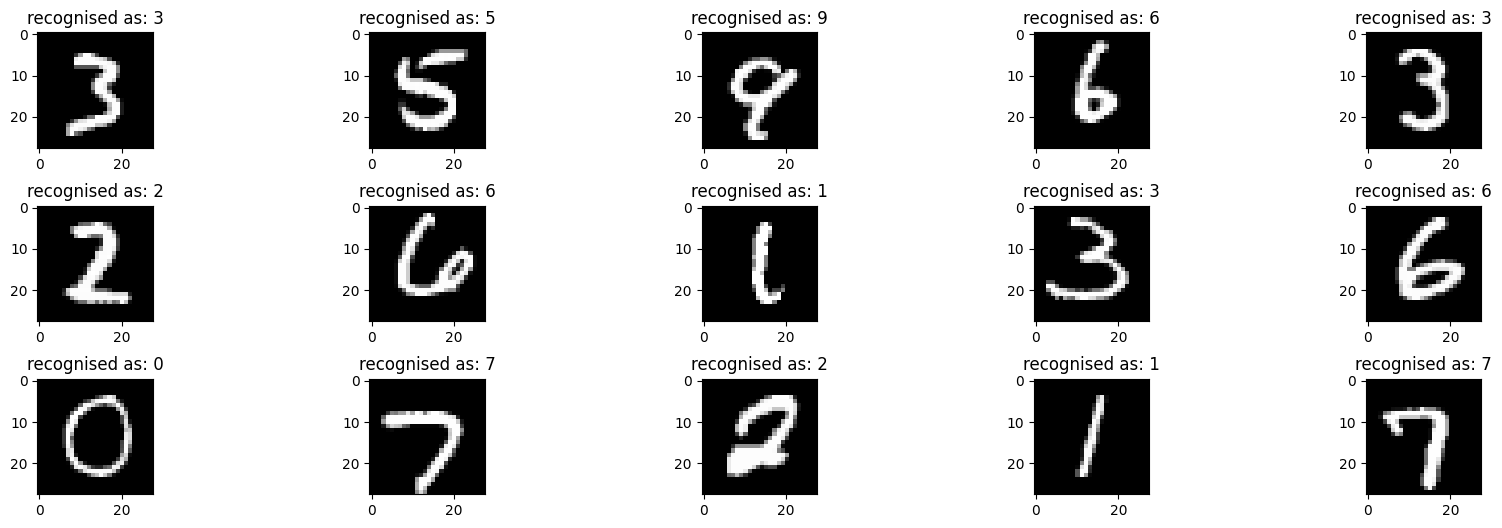

In [111]:
tmp = random.choice(range(data.testing_images.shape[0] - 15))
images = data.testing_images[tmp:tmp+15, :]
tmp = nn(images)
recognised_digits = []
for i in range(15):
    recognised_digits.append(utils.array_to_digit(tmp[i, :]))
utils.plot_images(images, labels=list(map(lambda x: f'recognised as: {x}', recognised_digits)))

#### Gradients average on different levels

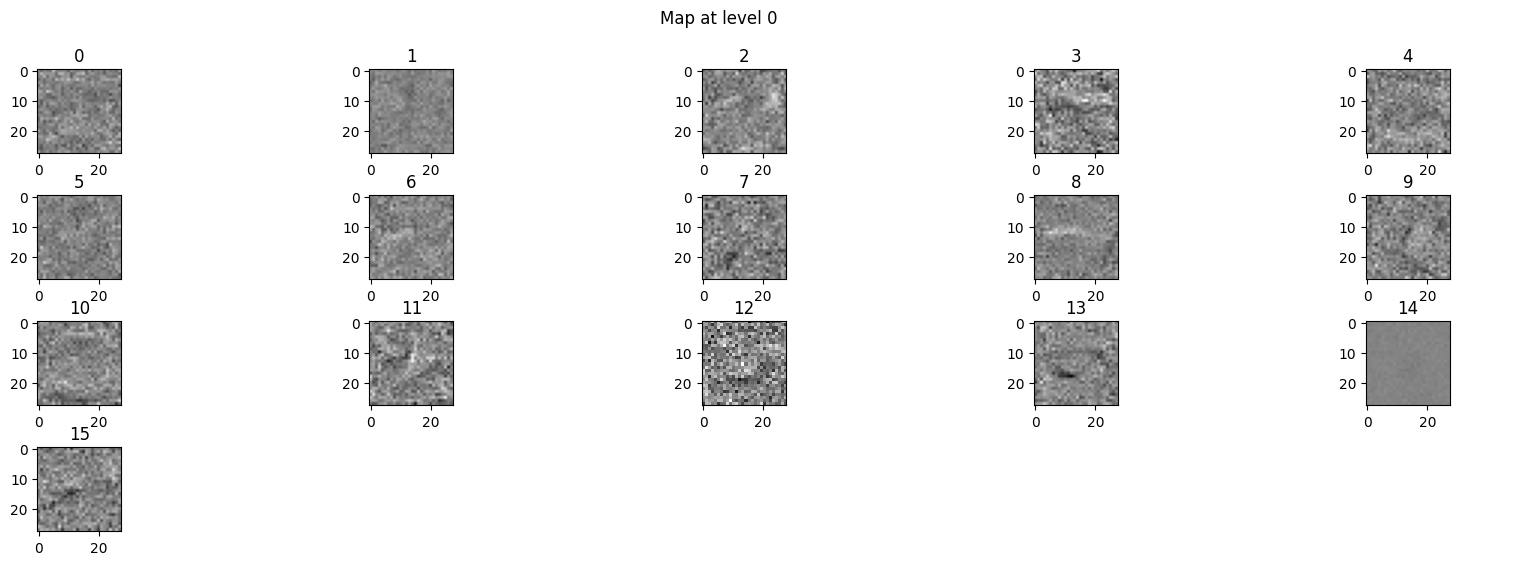

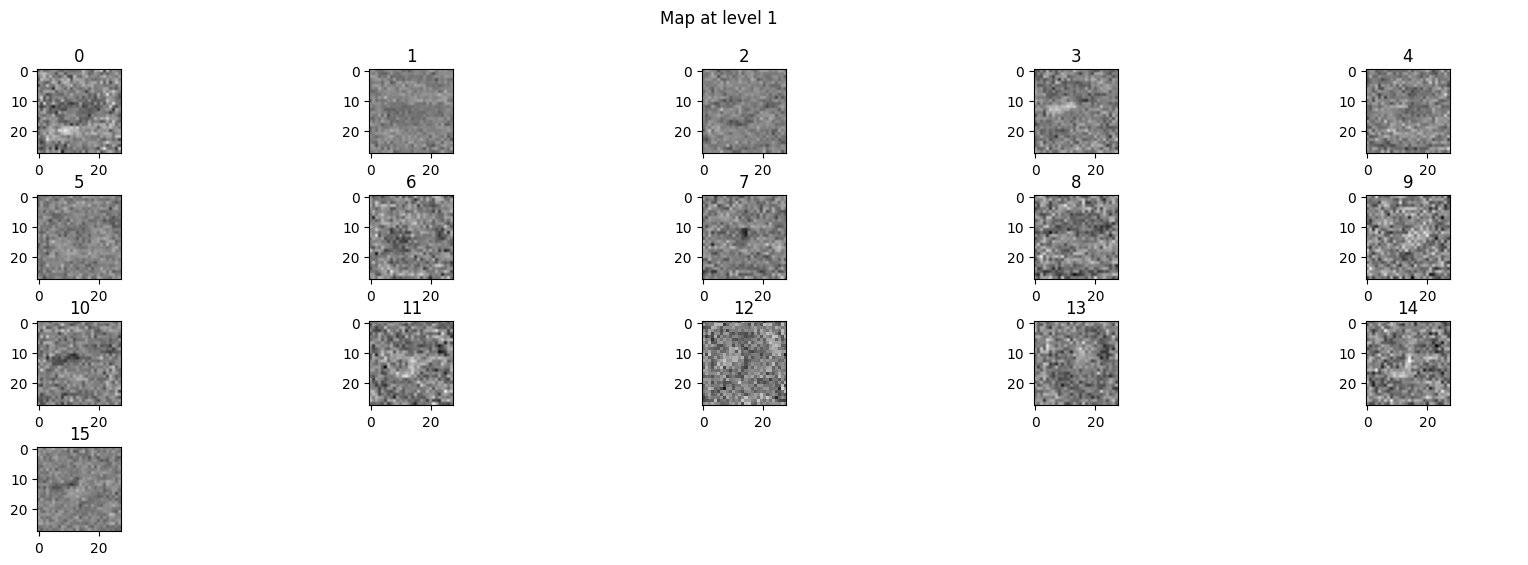

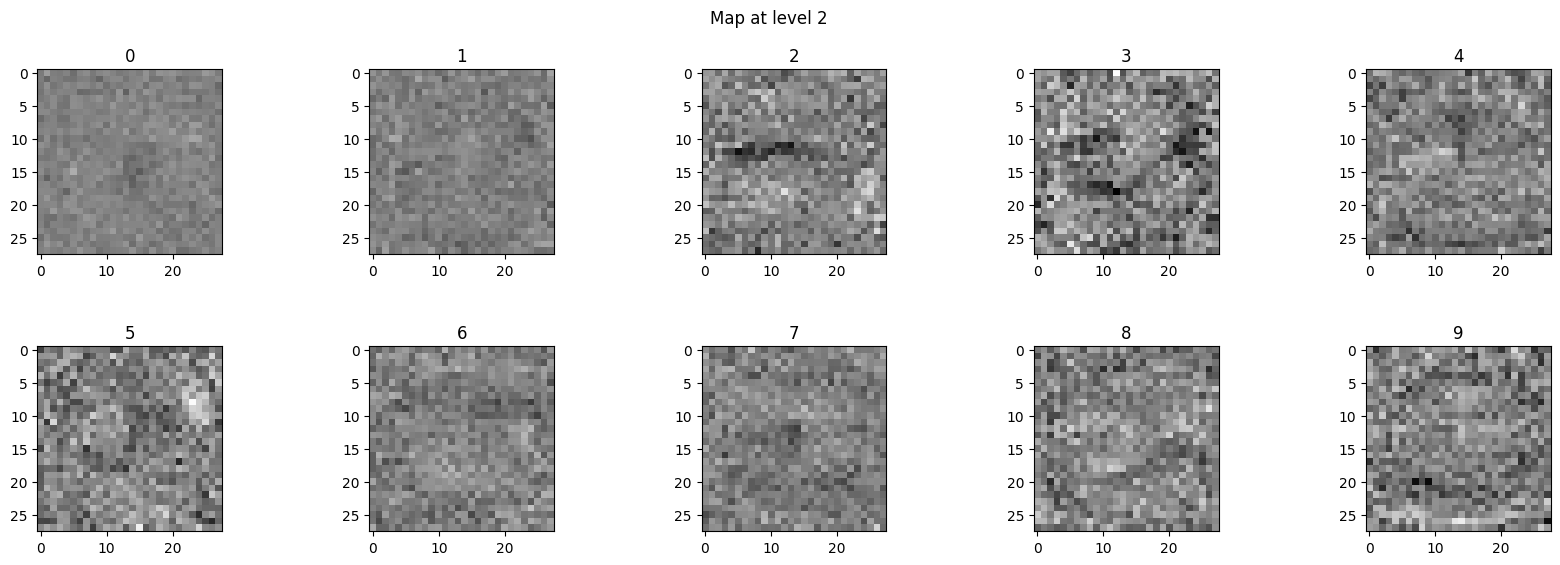

In [112]:
for i in range(0, nn.l_count - 1):
    img = data.testing_images
    gradient = nn.gradient(img, m=i + 1)
    gradient = (gradient - gradient.min()) / gradient.ptp()
    utils.plot_images(gradient, list(range(nn.transitions[i].output_dim)), title=f'Map at level {i}')